<a href="https://colab.research.google.com/github/balandongiv/mmocr_tutorial/blob/main/custom%20mmocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMOCR Tutorial

Welcome to MMOCR! This is the **unofficial** colab tutorial for using MMOCR. In this tutorial, you will learn how to

- Transform annotation in coco-like json format to MMOCR compatible format.
- Set custom configuration file
- Integrate mmocr config template extracted from `base` with user custom setting (Not sure if this is possible? or how to achieve:KIV)
- Train a text recognizer with a toy dataset. 

# Install MMOCR

When installing dependencies for mmocr, please ensure that all the dependency versions are compatible with each other. For instance, if CUDA 10.1 is installed, then the Pytorch version must be compatible with cu10.1. Please see [getting_started.md](docs/getting_started.md) for more details. 

In [1]:
%cd ..

/


### Check PyTorch version

In [2]:
!pip show torch

Name: torch
Version: 1.11.0+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


### Install Dependencies 

In [ ]:
# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

# Install mmdetection
!pip install mmdet

# Install mmocr
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -r requirements.txt
!pip install -v -e .

### Check Installed Dependencies Versions

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /mmocr/
!ls

1.11.0+cu113 True
2.24.1
1.5.0
11.3
GCC 7.3
0.6.0
/mmocr
CITATION.cff  docs	   mmocr.egg-info   requirements      setup.py
configs       LICENSE	   model-index.yml  requirements.txt  tests
demo	      MANIFEST.in  README.md	    resources	      tools
docker	      mmocr	   README_zh-CN.md  setup.cfg


#Perform Training on a Toy Dataset with MMOCR Recognizer
We now demonstrate how to perform training with an MMOCR recognizer. Since training a full academic dataset is time consuming (usually takes about several hours), we will train on the toy dataset for the SAR text recognition model and visualize the predictions.

Training a dataset usually consists of the following steps:
1. Convert the dataset into a format supported by MMOCR (e.g. COCO for text detection). The annotation file can be in either .txt or .lmdb format, depending on the size of the dataset. This step is usually applicable to customized datasets, since the datasets and annotation files we provide are already in supported formats. 
2. Modify the config for training. 
3. Train the model. 



## About the Toy Dataset

In this tutorial, we will be working with the dataset under the folder `toy_dataset`. 

Each of the image have the accompnying `annotation` file generated using the `labelme`

The images were stored under the following path

`/mmocr/tests/data/toy_dataset/imgs/test`

The annotation were stored under  the following path

`/mmocr/tests/data/toy_dataset/labelme`




In [5]:
# Print list of images and annotation available under the`toy_dataset` folder
!cat /mmocr/tests/data/toy_dataset/img_list.txt

img_10.jpg
img_1.jpg
img_2.jpg
img_3.jpg
img_4.jpg
img_5.jpg
img_6.jpg
img_7.jpg
img_8.jpg
img_9.jpg


We first get a sense of what the toy dataset looks like by visualizing one of the images and labels. 

/


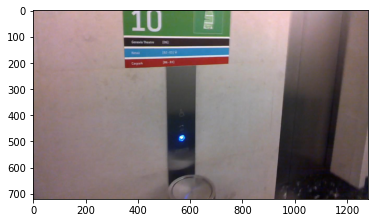

In [6]:
import mmcv
import matplotlib.pyplot as plt 

#To ensure we are in the root directory
%cd .. 

img = mmcv.imread('/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg')

plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Let visualise the annotation

In [7]:
!cat /mmocr/tests/data/toy_dataset/labelme/img_1.json

{
  "version": "5.0.1",
  "flags": {},
  "shapes": [
    {
      "label": "Genaxis Theatre",
      "points": [
        [
          377,
          117
        ],
        [
          463,
          117
        ],
        [
          465,
          130
        ],
        [
          378,
          130
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "[06]",
      "points": [
        [
          493,
          115
        ],
        [
          519,
          115
        ],
        [
          519,
          131
        ],
        [
          493,
          131
        ]
      ],
      "group_id": null,
      "shape_type": "polygon",
      "flags": {}
    },
    {
      "label": "###",
      "points": [
        [
          374,
          155
        ],
        [
          409,
          155
        ],
        [
          409,
          170
        ],
        [
          374,
          170
        ]
      ],
      "group

## Prepare Annotation to MMOCR format 

Since the annotations are in COCO format, we need to firstly convert annotation in labelme format to MMOCR's annotation format using the `labelme_converter.py`.

For this particular example, we will convert the labelme format annotation in `/mmocr/tests/data/toy_dataset/labelme` to MMOCR detection labels instances_training `.txt` and export the cropped image patches for recognition task to `/mmocr/tests/data/toy_dataset/crops`. It is worth to note that the following setting would not output the `test_label.txt` as there is no test set. This information is important  when assigning  `test_anno_file1` to `train_label.txt` in subsequent step.

In Google colab, it is essential to add a `!` before the Python command.


In [8]:
!python /mmocr/tools/data/common/labelme_converter.py /mmocr/tests/data/toy_dataset/labelme /mmocr/tests/data/toy_dataset/imgs/test /mmocr/tests/data/toy_dataset --tasks recog --format txt

[>>] 10/10, 62.3 task/s, elapsed: 0s, ETA:     0s
finish


Let have a look what files has been generated from the previous calling

In [9]:
# List of crop images that being crop in accordance to the bounding box
import os
print([os.path.join(path, name) for path, subdirs, files in os.walk('/mmocr/tests/data/toy_dataset/crops') for name in files])

['/mmocr/tests/data/toy_dataset/crops/img_8/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_3.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_6/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_6/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_7/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_7/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_3/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_3/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_3.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_2/c

Lets visualise the MMOCR detection labels instances_training `.txt`

In [10]:
!cat /mmocr/tests/data/toy_dataset/train_label.txt

/mmocr/tests/data/toy_dataset/crops/img_3/crop_0.jpg fusionopolis
/mmocr/tests/data/toy_dataset/crops/img_3/crop_1.jpg fusionopolis
/mmocr/tests/data/toy_dataset/crops/img_9/crop_0.jpg EXIT
/mmocr/tests/data/toy_dataset/crops/img_9/crop_1.jpg STAGE
/mmocr/tests/data/toy_dataset/crops/img_6/crop_0.jpg Reserve
/mmocr/tests/data/toy_dataset/crops/img_6/crop_1.jpg CAUTION
/mmocr/tests/data/toy_dataset/crops/img_10/crop_0.jpg HarbourFront
/mmocr/tests/data/toy_dataset/crops/img_10/crop_1.jpg CC22
/mmocr/tests/data/toy_dataset/crops/img_10/crop_2.jpg bua
/mmocr/tests/data/toy_dataset/crops/img_8/crop_0.jpg WHY
/mmocr/tests/data/toy_dataset/crops/img_8/crop_1.jpg PAY
/mmocr/tests/data/toy_dataset/crops/img_8/crop_2.jpg FOR
/mmocr/tests/data/toy_dataset/crops/img_8/crop_3.jpg NOTHING?
/mmocr/tests/data/toy_dataset/crops/img_1/crop_0.jpg Genaxis Theatre
/mmocr/tests/data/toy_dataset/crops/img_1/crop_1.jpg [06]
/mmocr/tests/data/toy_dataset/crops/img_1/crop_2.jpg 62-03
/mmocr/tests/data/toy_data

In [11]:
!cat /mmocr/tests/data/toy_dataset/instances_training.txt

{"file_name": "img_3.jpg", "height": 720, "width": 1280, "annotations": [{"iscrowd": 0, "category_id": 1, "bbox": [58, 71, 136, 52], "segmentation": [[58, 80, 191, 71, 194, 114, 61, 123]], "text": "fusionopolis"}, {"iscrowd": 1, "category_id": 1, "bbox": [147, 21, 29, 15], "segmentation": [[147, 21, 176, 21, 176, 36, 147, 36]], "text": "###"}, {"iscrowd": 1, "category_id": 1, "bbox": [326, 75, 65, 38], "segmentation": [[328, 75, 391, 81, 387, 112, 326, 113]], "text": "###"}, {"iscrowd": 1, "category_id": 1, "bbox": [401, 76, 47, 35], "segmentation": [[401, 76, 448, 84, 445, 108, 402, 111]], "text": "###"}, {"iscrowd": 1, "category_id": 1, "bbox": [780, 6, 236, 36], "segmentation": [[780, 7, 1015, 6, 1016, 37, 788, 42]], "text": "###"}, {"iscrowd": 0, "category_id": 1, "bbox": [221, 72, 91, 46], "segmentation": [[221, 72, 311, 80, 312, 117, 222, 118]], "text": "fusionopolis"}, {"iscrowd": 1, "category_id": 1, "bbox": [113, 19, 31, 14], "segmentation": [[113, 19, 144, 19, 144, 33, 113, 3

## Configuration file

The MMOCR's config system incorporate modular and inheritance design into our, which is convenient to conduct various experiments. 

Lets visualise the `sar_r31_parallel_decoder_toy_dataset` config.

In [ ]:
from mmcv import Config

# Note the addition of /mmocr preceding text
cfg = Config.fromfile('/mmocr/configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py') 
print(f'Config:\n{cfg.pretty_text}')

The MMOCR have the build-in facility to generate the configfor config and config files.

The config file structure consist on the parameter `model`, `data & pipeline`, `training schedule`, and `runtime setting`. Please refer to [config file structure](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#config-file-structure) for detailed documentation

Set custom configuration file. Most of the values are based on 
 `sar_r31_parallel_decoder_toy_dataset` config value.

In [85]:
# log_config = dict(interval = 40, hooks = [dict(type = 'TextLoggerHook')]) # Purposely disable and tweak in next cell. Due to Colab consideration
dist_params = dict(backend = 'nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(type = 'AttnConvertor', dict_type = 'DICT90', with_unknown = True)

model = dict(
        type = 'SARNet',
        backbone = dict(type = 'ResNet31OCR'),
        encoder = dict(
                type = 'SAREncoder', enc_bi_rnn = False, enc_do_rnn = 0.1, enc_gru = False),
        decoder = dict(
                type = 'ParallelSARDecoder',
                enc_bi_rnn = False,
                dec_bi_rnn = False,
                dec_do_rnn = 0,
                dec_gru = False,
                pred_dropout = 0.1,
                d_k = 512,
                pred_concat = True),
        loss = dict(type = 'SARLoss'),
        label_convertor = dict(
                type = 'AttnConvertor', dict_type = 'DICT90', with_unknown = True),
        max_seq_len = 30)

# optimizer = dict(type = 'Adam', lr = 0.000125)  # Purposely disable and tweak in next cell. Due to Colab consideration
optimizer_config = dict(grad_clip = None)
# lr_config = dict(policy = 'step', step = [3, 4], warmup = None) # Purposely disable and tweak in next cell. Due to Colab consideration



runner = dict(type = 'EpochBasedRunner', max_epochs = 5)

checkpoint_config = dict(interval = 1)

img_norm_cfg = dict(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])

train_pipeline = [                                            # Training pipeline
                  dict(type = 'LoadImageFromFile'),           # First pipeline to load images from file path
                  dict(
                        type = 'ResizeOCR',
                        height = 48,
                        min_width = 48,
                        max_width = 160,
                        keep_aspect_ratio = True,
                        width_downsample_ratio = 0.25),
                  dict(type = 'ToTensorOCR'),
                  dict(type = 'NormalizeOCR', mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
                  dict(
                  type = 'Collect',
                  keys = ['img'],
                  meta_keys = [
                  'filename', 'ori_shape', 'resize_shape', 'text', 'valid_ratio'
                  ])
                  ]


test_pipeline = [
        dict(type = 'LoadImageFromFile'),
        dict(
            type = 'MultiRotateAugOCR',
            rotate_degrees = [0, 90, 270],
            transforms = [
                dict(
                    type = 'ResizeOCR',
                    height = 48,
                    min_width = 48,
                    max_width = 160,
                    keep_aspect_ratio = True,
                    width_downsample_ratio = 0.25),
                dict(type = 'ToTensorOCR'),
                dict(
                    type = 'NormalizeOCR', mean = [0.5, 0.5, 0.5], std = [0.5, 0.5,
                        0.5]),
                dict(
                    type = 'Collect',
                    keys = ['img'],
                    meta_keys = [
                        'filename', 'ori_shape', 'resize_shape', 'valid_ratio',
                        'img_norm_cfg', 'ori_filename', 'img_shape'
                    ])
            ])
    ]

evaluation = dict(interval = 1, metric = 'acc')



Adjust the path reflecting where the crop images and annotation being saved

In [90]:
# log_config = dict(interval = 40, hooks = [dict(type = 'TextLoggerHook')]) # Purposely disable and tweak in next cell. Due to Colab consideration
dist_params = dict(backend = 'nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(type = 'AttnConvertor', 
                       dict_type = 'DICT90', 
                       with_unknown = True)

model = dict(
        type = 'SARNet',
        backbone = dict(type = 'ResNet31OCR'),
        encoder = dict(
                type = 'SAREncoder', enc_bi_rnn = False, enc_do_rnn = 0.1, enc_gru = False),
        decoder = dict(
                type = 'ParallelSARDecoder',
                enc_bi_rnn = False,
                dec_bi_rnn = False,
                dec_do_rnn = 0,
                dec_gru = False,
                pred_dropout = 0.1,
                d_k = 512,
                pred_concat = True),
        loss = dict(type = 'SARLoss'),
        label_convertor = dict(
                type = 'AttnConvertor', dict_type = 'DICT90', with_unknown = True),
        max_seq_len = 30)

# optimizer = dict(type = 'Adam', lr = 0.000125)  # Purposely disable and tweak in next cell. Due to Colab consideration
optimizer_config = dict(grad_clip = None)
# lr_config = dict(policy = 'step', step = [3, 4], warmup = None) # Purposely disable and tweak in next cell. Due to Colab consideration



runner = dict(type = 'EpochBasedRunner', max_epochs = 5)

checkpoint_config = dict(interval = 1)

img_norm_cfg = dict(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])

train_pipeline = [                                            # Training pipeline
                  dict(type = 'LoadImageFromFile'),           # First pipeline to load images from file path
                  dict(
                        type = 'ResizeOCR',
                        height = 48,
                        min_width = 48,
                        max_width = 160,
                        keep_aspect_ratio = True,
                        width_downsample_ratio = 0.25),
                  dict(type = 'ToTensorOCR'),
                  dict(type = 'NormalizeOCR', mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
                  dict(
                  type = 'Collect',
                  keys = ['img'],
                  meta_keys = [
                  'filename', 'ori_shape', 'resize_shape', 'text', 'valid_ratio'
                  ])
                  ]


test_pipeline = [
        dict(type = 'LoadImageFromFile'),
        dict(
            type = 'MultiRotateAugOCR',
            rotate_degrees = [0, 90, 270],
            transforms = [
                dict(
                    type = 'ResizeOCR',
                    height = 48,
                    min_width = 48,
                    max_width = 160,
                    keep_aspect_ratio = True,
                    width_downsample_ratio = 0.25),
                dict(type = 'ToTensorOCR'),
                dict(
                    type = 'NormalizeOCR', mean = [0.5, 0.5, 0.5], std = [0.5, 0.5,
                        0.5]),
                dict(
                    type = 'Collect',
                    keys = ['img'],
                    meta_keys = [
                        'filename', 'ori_shape', 'resize_shape', 'valid_ratio',
                        'img_norm_cfg', 'ori_filename', 'img_shape'
                    ])
            ])
    ]

evaluation = dict(interval = 1, metric = 'acc')


dataset_type = 'OCRDataset'
root = '/mmocr/tests/data/toy_dataset'
img_prefix = '/mmocr/tests/data/toy_dataset/crops'
train_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.txt'


test_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.txt'


train1 = dict(type = 'OCRDataset',
              img_prefix = img_prefix,
              ann_file = train_anno_file1,
              loader = dict(type = 'AnnFileLoader',
                                  repeat = 100,
                              file_format = 'txt',
                              file_storage_backend = 'disk',
                              parser = dict(
                                      type = 'LineStrParser',
                                      keys = ['filename', 'text'],
                                      keys_idx = [0, 1],
                                      separator = ' ')),
                      pipeline = None,
                      test_mode = False)




test = dict(
        type = 'OCRDataset',
        img_prefix = img_prefix, # Manually change, previous values >'tests/data/ocr_toy_dataset/imgs',
        ann_file = train_anno_file1, # Manually change, previous > 'tests/data/ocr_toy_dataset/label.lmdb',
        loader = dict(
                type = 'AnnFileLoader',
                repeat = 1,
                file_format = 'txt', # Previously 'lmdb',
                file_storage_backend = 'disk',
                parser = dict(type = 'LineStrParser', # Manually change, previous > 'LineJsonParser', 
                              keys = ['filename', 'text'])),
        pipeline = None,
        test_mode = True)


train_list = [train1,
        # The following lines is disable since we r not testing on the .lmdb annotation
        train1
          ]
test_list = [test
    ]

loader_dt_train=dict(type = 'AnnFileLoader',
                      repeat = 100,
                      file_format = 'txt',
                      file_storage_backend = 'disk',
                      parser = dict(type = 'LineStrParser',
                                    keys = ['filename', 'text'],
                                    keys_idx = [0, 1],
                                    separator = ' '))

train_datasets1=dict(type = 'OCRDataset',
                    img_prefix =  img_prefix, # Manually change, previous values > 'tests/data/ocr_toy_dataset/imgs',
                    ann_file = train_anno_file1, # Manually change, previous > 'tests/data/ocr_toy_dataset/label.txt',
                    loader = loader_dt_train,
                    pipeline = None,
                    test_mode = False)

train_datasets2=dict(
                        type = 'OCRDataset',
                        img_prefix = img_prefix, # Manually change, previous values >'tests/data/ocr_toy_dataset/imgs',
                        ann_file = train_anno_file1, # Manually change, previous > 'tests/data/ocr_toy_dataset/label.lmdb',
                        loader = dict(
                                type = 'AnnFileLoader',
                                repeat = 100,
                                file_format = 'txt', # Previously 'lmdb',
                                file_storage_backend = 'disk',
                                parser = dict(
                                        type = 'LineStrParser', # Manually change, previous > 'LineJsonParser', 
                                        keys = ['filename', 'text'])),
                        pipeline = None,
                        test_mode = False)
val_dataset=dict(
                        type = 'OCRDataset',
                        img_prefix = img_prefix, # Manually change, previous values >'tests/data/ocr_toy_dataset/imgs',
                        ann_file =  train_anno_file1, # Manually change, previous > 'tests/data/ocr_toy_dataset/label.lmdb',
                        loader = dict(
                                type = 'AnnFileLoader',
                                repeat = 1,
                                file_format = 'txt', # Previously 'lmdb',
                                file_storage_backend = 'disk',
                                parser = dict(
                                        type = 'LineStrParser', # Manually change, previous > 'LineJsonParser', 
                                        keys = ['filename', 'text'])),
                        pipeline = None,
                        test_mode = True)

transformer_val=[dict(type = 'ResizeOCR',
                      height = 48,
                      min_width = 48,
                      max_width = 160,
                      keep_aspect_ratio = True,
                      width_downsample_ratio = 0.25),
                dict( type = 'ToTensorOCR'),
                dict( type = 'NormalizeOCR',
                      mean = [0.5, 0.5, 0.5],
                      std = [0.5, 0.5, 0.5]),
                dict( type = 'Collect',
                      keys = ['img'],
                      meta_keys = [
                        'filename', 'ori_shape', 'resize_shape',
                        'valid_ratio', 'img_norm_cfg', 'ori_filename',
                        'img_shape'
                    ])
                        ]
data = dict(
        workers_per_gpu = 2,                            # Worker to pre-fetch data for each single GPU
        samples_per_gpu = 8,                            # Batch size of a single GPU
        train = dict(                                   # train data config
                type = 'UniformConcatDataset',
                datasets = [train_datasets1,
                            train_datasets2             # The following lines is disable since we r not testing on the .lmdb annotation
                            ],
                pipeline = [
                    dict(type = 'LoadImageFromFile'),
                    dict(
                        type = 'ResizeOCR',
                        height = 48,
                        min_width = 48,
                        max_width = 160,
                        keep_aspect_ratio = True,
                        width_downsample_ratio = 0.25),
                    dict(type = 'ToTensorOCR'),
                    dict(
                        type = 'NormalizeOCR', mean = [0.5, 0.5, 0.5], std = [0.5, 0.5,
                            0.5]),
                    dict(
                        type = 'Collect',
                        keys = ['img'],
                        meta_keys = [
                            'filename', 'ori_shape', 'resize_shape', 'text',
                            'valid_ratio'
                        ])
                ]),
            # Does data require in this particular example?
        val = dict(type = 'UniformConcatDataset',
                datasets = [val_dataset],
                pipeline = [
                    dict(type = 'LoadImageFromFile'),
                    dict(type = 'MultiRotateAugOCR',
                        rotate_degrees = [0, 90, 270],
                        transforms = transformer_val)
                            ]),
        test = dict(
                type = 'UniformConcatDataset',
                datasets = [
                    dict(
                        type = 'OCRDataset',
                        img_prefix = img_prefix, # Manually change, previous values > 'tests/data/ocr_toy_dataset/imgs',
                        ann_file =  train_anno_file1, # Manually change, previous > 'tests/data/ocr_toy_dataset/label.lmdb',
                        loader = dict(
                                type = 'AnnFileLoader',
                                repeat = 1,
                                file_format = 'txt', # Previously 'lmdb',
                                file_storage_backend = 'disk',
                                parser = dict(
                                        type = 'LineStrParser', # Manually change, previous > 'LineJsonParser', 
                                        keys = ['filename', 'text'])),
                        pipeline = None,
                        test_mode = True)
                ],
                pipeline = [
                    dict(type = 'LoadImageFromFile'),
                    dict(
                        type = 'MultiRotateAugOCR',
                        rotate_degrees = [0, 90, 270],
                        transforms = [
                            dict(
                                type = 'ResizeOCR',
                                height = 48,
                                min_width = 48,
                                max_width = 160,
                                keep_aspect_ratio = True,
                                width_downsample_ratio = 0.25),
                            dict(type = 'ToTensorOCR'),
                            dict(
                                type = 'NormalizeOCR',
                                mean = [0.5, 0.5, 0.5],
                                std = [0.5, 0.5, 0.5]),
                            dict(
                                type = 'Collect',
                                keys = ['img'],
                                meta_keys = [
                                    'filename', 'ori_shape', 'resize_shape',
                                    'valid_ratio', 'img_norm_cfg', 'ori_filename',
                                    'img_shape'
                                ])
                        ])
                ]))



from mmdet.apis import set_random_seed

# Set up working dir to save files and logs.
work_dir = '/mmocr/demo/tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.

optimizer = dict(type = 'Adam', lr = 0.001 / 8)


lr_config = dict(policy = 'step', step = [3, 4], warmup = None) # Set warmup to None when work in Colab

# Choose to log training results every 40 images to reduce the size of log file. 
log_config = dict(interval = 40, hooks = [dict(type = 'TextLoggerHook')])

# Set seed thus the results are more reproducible
seed = 0
set_random_seed(0, deterministic=False)
gpu_ids = range(1)




####################


from mmcv import Config


cfg = Config(dict(log_config = log_config,
                  dist_params=dist_params,
                  log_level =log_level,
                  load_from=load_from,
                  resume_from=resume_from,
                  workflow=workflow,
                  opencv_num_threads=opencv_num_threads,
                  mp_start_method=mp_start_method,
                  label_convertor=label_convertor,
                  model=model,
                  optimizer=optimizer,                # Specially tweak for Google Colab particularly the  lr
                  optimizer_config=optimizer_config,
                  lr_config=lr_config,
                  runner=runner,
                  checkpoint_config=checkpoint_config,\
                  img_norm_cfg=img_norm_cfg,
                  train_pipeline=train_pipeline,
                  test_pipeline=test_pipeline,\
                  dataset_type=dataset_type,
                  root=root,
                  img_prefix=img_prefix,
                  train_anno_file1=train_anno_file1,\
                  train1=train1,
                  # train_anno_file2=train_anno_file2,  # Disable as this is for 1mdb
                  # train2=train2,                      # Disable as this is for 1mdb
                  test_anno_file1=test_anno_file1,
                  test=test,                            # Disable as this is for 1mdb
                  train_list=train_list,
                  test_list=test_list,
                  data=data,
                  evaluation=evaluation,
                  work_dir=work_dir,
                  seed =seed,                           # Specially tweak for Google Colab
                  gpu_ids =gpu_ids,                     # Specially tweak for Google Colab
                  ))


print(f'Config:\n{cfg.pretty_text}')

Config:
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='step', step=[3, 4], warmup=No

In order to perform inference for SAR on colab, we need to adjust the config values to accommodate some of the settings of colab such as the number of GPU available. 

In [88]:
from mmdet.apis import set_random_seed

# Set up working dir to save files and logs.
work_dir = '/mmocr/demo/tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.

optimizer = dict(type = 'Adam', 
                 lr = 0.001 / 8)


lr_config = dict(policy = 'step', 
                 step = [3, 4], 
                 warmup = None) # Set warmup to None when work in Colab

# Choose to log training results every 40 images to reduce the size of log file. 
log_config = dict(interval = 40, 
                  hooks = [dict(type = 'TextLoggerHook')])

# Set seed thus the results are more reproducible
seed = 0
set_random_seed(0, deterministic=False)
gpu_ids = range(1)


Lets create the configration file

In [89]:
from mmcv import Config


cfg = Config(dict(log_config = log_config,
                  dist_params=dist_params,
                  log_level =log_level,
                  load_from=load_from,
                  resume_from=resume_from,
                  workflow=workflow,
                  opencv_num_threads=opencv_num_threads,
                  mp_start_method=mp_start_method,
                  label_convertor=label_convertor,
                  model=model,
                  optimizer=optimizer,                # Specially tweak for Google Colab particularly the  lr
                  optimizer_config=optimizer_config,
                  lr_config=lr_config,
                  runner=runner,
                  checkpoint_config=checkpoint_config,\
                  img_norm_cfg=img_norm_cfg,
                  train_pipeline=train_pipeline,
                  test_pipeline=test_pipeline,\
                  dataset_type=dataset_type,
                  root=root,
                  img_prefix=img_prefix,
                  train_anno_file1=train_anno_file1,\
                  train1=train1,
                  # train_anno_file2=train_anno_file2,  # Disable as this is for 1mdb
                  # train2=train2,                      # Disable as this is for 1mdb
                  test_anno_file1=test_anno_file1,
                  test=test,                            # Disable as this is for 1mdb
                  train_list=train_list,
                  test_list=test_list,
                  data=data,
                  evaluation=evaluation,
                  work_dir=work_dir,
                  seed =seed,                           # Specially tweak for Google Colab
                  gpu_ids =gpu_ids,                     # Specially tweak for Google Colab
                  ))


print(f'Config:\n{cfg.pretty_text}')

Config:
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='step', step=[3, 4], warmup=No

## Train the SAR Text Recognizer 
Finally, we train the SAR text recognizer on the toy dataset for five epochs. 

This steps took about ~ 5 minutes to complete

In [51]:
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)] # Pu

In [ ]:

# Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

## Test and Visualize the Predictions

For completeness, we also perform testing on the latest checkpoint and evaluate the results with hmean-iou metrics. The predictions are saved in the ./outputs file. 

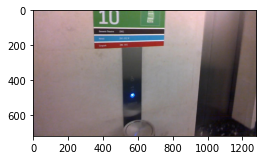

In [43]:
# Visualize the testing image
img='/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg'
# img = '/mmocr/tests/data/ocr_toy_dataset/imgs/1036169.jpg' # original value > './tests/data/ocr_toy_dataset/imgs/1036169.jpg'
_img = mmcv.imread(img)
plt.figure(figsize=(4, 4))
plt.imshow(mmcv.bgr2rgb(_img))
plt.show()

In [45]:
from mmocr.apis import init_detector, model_inference
# work_dir = '/mmocr/demo/tutorial_exps' # To recap, we set the working dir
img='/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg'
# img = '/mmocr/tests/data/ocr_toy_dataset/imgs/1036169.jpg' # original value > './tests/data/ocr_toy_dataset/imgs/1036169.jpg'
checkpoint = "/mmocr/demo/tutorial_exps/epoch_5.pth"   # Original value "./demo/tutorial_exps/epoch_5.pth" > please expect error
out_file = 'outputs/1036169s.jpg'

model = init_detector(cfg, checkpoint, device="cuda:0")
if model.cfg.data.test['type'] == 'ConcatDataset':
    model.cfg.data.test.pipeline = model.cfg.data.test['datasets'][0].pipeline


result = model_inference(model, img)
print(f'result: {result}')

img = model.show_result(img, result, 
                        out_file=out_file, 
                        show=False)

mmcv.imwrite(img, out_file)

load checkpoint from local path: /mmocr/demo/tutorial_exps/epoch_5.pth
result: {'text': 'citi', 'score': 0.995453804731369}


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


True

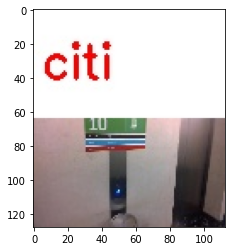

In [46]:
# Visualize the results
predicted_img = mmcv.imread('./outputs/1036169s.jpg')
plt.figure(figsize=(4, 4))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()